In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from graphgen import EUC_2D
from algs import minimum_perfect_matching #suboptimal, use Blossom V if you need to actually use it
from algs import brute_force
import networkx as nx
import itertools as it
import numpy as np

# Christofides algorithm

1. Create a minimum spanning tree T of G.
1. Let O be the set of vertices with odd degree in T. By the handshaking lemma, O has an even number of vertices.
1. Find a minimum-weight perfect matching M in the induced subgraph given by the vertices from O.
1. Combine the edges of M and T to form a connected multigraph H in which each vertex has even degree.
1. Form an Eulerian circuit in H.
1. Make the circuit found in previous step into a Hamiltonian circuit by skipping repeated vertices (shortcutting)


The Christofides algorithim is one of the key algorithms regarding the travelling salesman problem. It has a $\frac{3}{2}$ bound on it's apprioximation, meaning the tour it produces, at most, is $\frac{3}{2}$ worse than the optimal tour. Here's a demonstration on a random Euclidean graph. The Christofides algorithm is one of the first approximation algorithms, formtive in the building of the field.

In [2]:
def Christofides(G):
    T = nx.algorithms.minimum_spanning_tree(G)
    O = {n for n, d in T.degree(T.nodes_iter()).items() if d%2 == 1}
    induced_subgraph = nx.Graph(G.subgraph(O))            
    M = minimum_perfect_matching(induced_subgraph)

    T.add_weighted_edges_from([(u,v,M[u][v]['weight']) for u, v in M.edges()])
    H = T
    
    seen = set()
    tour = []
    for u, _ in nx.eulerian_circuit(H):
        if not u in seen:
            tour.append(u)
            seen.add(u)
    return tour

In [3]:
G = EUC_2D(10)
opt_christofides = Christofides(G)

In [4]:
cost = 0
for u, v in zip(opt_christofides, opt_christofides[1:]):
    cost += G[u][v]['weight']
opt_christofides, cost

([0, 7, 8, 5, 9, 3, 6, 4, 2, 1], 11.674609901636719)

In [5]:
opt, _ = brute_force(G)
opt.opt_tour

0    (8, 7, 6, 0, 4, 2, 1, 3, 9, 5)
Name: opt_tour, dtype: object

In [6]:
opt.cost

0    8.792924
Name: cost, dtype: float64

In [7]:
1.5*opt.cost #upper bound on cost

0    13.189386
Name: cost, dtype: float64

# Lin-kernighan ($K$-opt heuristic)

The Lin-kernighan heuristic is a way to "settle" a tour into a local optimum by investigating small, local changes in the tour. The locality of the change is the parameter $k$, which specifies how many 2-node pairs to swap and check if the cost is lower.


This is what a 2-opt switch looks like. If the new tour is lower cost than the unperturbed tour, we store it again and run the whole process over. Speeding this up and "boosting" out of local minima to better solutions can be achieved with higher $k$.
![intuitive 2-opt process](https://upload.wikimedia.org/wikipedia/en/thumb/f/f2/Showing_a_step_of_the_two-opt_heuristic.png/440px-Showing_a_step_of_the_two-opt_heuristic.png)


Let's run the two-opt until there's no improvement.

In [8]:
def two_opt(G, tour):
    from functools import reduce
    #Consider all 2-node groups in the tour (Exhaustive enumeration)
    cost = lambda t: sum([G[u][v]['weight'] for u, v in zip(t, t[1:])])

    def inner(i_tour):
        for i in range(len(i_tour)):
            for i2 in range(len(i_tour)):
                if i<i2:
                    if i2-i < 2:
                        continue
                    tour_c = i_tour[:]
                    tour_c[i:i2] = list(reversed(i_tour[i:i2]))
                    if cost(tour_c) < opt:
                        return tour_c #not done yet, have to re-run since "bubble" has to be re-evaluated
        return True #No advantageous swap
    old_res = tour
    opt = cost(tour)
    it_opts = []
    while True:
        res = inner(old_res)
        if res == True:
            return (old_res, it_opts)
        if type(res) == list:
            it_opts.append(res)
            old_res = res
            opt = cost(res)

In [14]:
G = EUC_2D(50)
res, ts = two_opt(G, list(range(len(G)))) #naive seed tour
print(res) #That looks different! We've settled into a local minima
cost = lambda t: sum([G[u][v]['weight'] for u, v in zip(t, t[1:])])
print("Pre $K$-opt: ", cost(range(len(G))))
print("Post $K$-opt cost: ", cost(res))

[43, 18, 10, 16, 15, 21, 39, 3, 13, 33, 47, 29, 25, 22, 46, 48, 20, 34, 17, 5, 32, 4, 9, 27, 8, 35, 45, 41, 38, 37, 40, 11, 0, 2, 23, 28, 30, 14, 26, 19, 42, 24, 31, 36, 1, 12, 7, 44, 6, 49]
Pre $K$-opt:  80.0384254487
Post $K$-opt cost:  23.4920708742


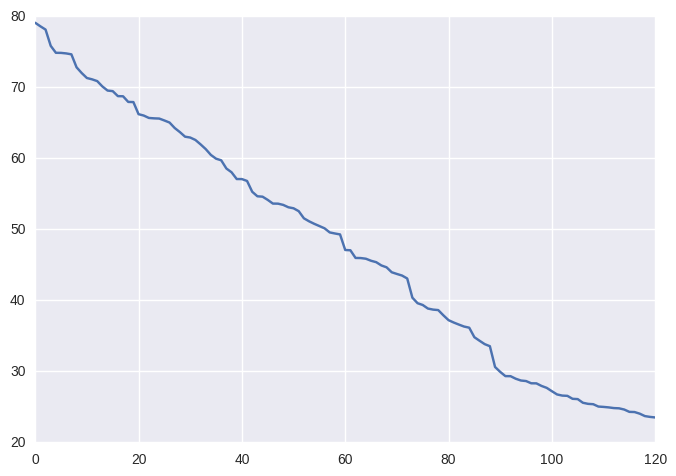

In [15]:
plt.figure()
plt.plot([cost(t) for t in ts]) #Let's see how cost drops per iteration of 2-opt
plt.show()

For Euclidean case, $\frac{\texttt{Tour}_{k-opt}}{\texttt{Tour}_{opt}} \leq O(\log |V|)$.

# Arora and JSB Mitchell PTAS

Sanjeev Arora and JSB Mitchell proposed a PTAS for the Travelling salesman problem. After looking at the problem for a while and understanding the algorithm intuitivley, the best I can provide is a rationale for a lack of implementation. 

https://pdfs.semanticscholar.org/7056/caeba3fa0d4064d03ef53fc2090974b70c71.pdf

    The Traveling Salesman Problem (TSP) is perhaps
    the most famous optimization problem in the set NP-hard.
    Many problems that are natural applications in computer
    science and engineering can be modeled using TSP and
    therefore, researchers are searching implementations focusing
    on the quality of the produced solution and their
    computational time. An innovative Polynomial-Time
    Approximation Scheme (PTAS) for the Euclidean TSP was
    given by Sanjeev Arora. To date, there is no evidence that it
    can be implemented to be practically useful
    
    
    Experimental results show that Arora´s PTAS is practically feasible. Table I and Table II show that in spite of its good performance, it seems that our approach must be improved to generate more approximate solutions. In most cases the significant theoretical results are lost due to implementation decisions. We think the quality of the solutions had to do with implementation aspects linked to data structures and the need to give more hints about which portals must be used by the tour.
    
    
This is a team with a substantial amount of knowlege behind them. Hopefully this provides a sense of the scale of the task